In [91]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()

import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from inspect_tables import plot_date_relplot, draw_report, overview

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100

targhe = [
"FY293YC", "FY295YC", "FY298YC", "FY294YC", "FY296YC", "FV903SK", "FV904SK", "FV906SK", "FV907SK", "FV908SK", "FZ330SC", "FV913SK", "FV914SK", "FY402YC", "FY403YC", "ZB477AN", "ZB473AN", "ZB474AN", "ZB476AN", "ZB475AN", "ZB478AN", "ZB137AR", "ZB139AR", "ZB150AR", "ZB127AR", "ZB132AR", "ZB128AR", "ZB131AR", "ZB130AR", "FY400YC", "ZB135AR", "ZB136AR", "ZB134AR", "ZB373AN", "FY401YC", "CW363HC", "CW367HC", "FP698BP", "FP699BP", "CW365HC", "CW368HC", "CN433CA", "FV989FV", "FV990FV", "FV991FV", "FV995FV", "FV996FV", "FV997FV", "FV992FV", "FV985FV", "FV987FV", "FV988FV", "FV993FV", "FV994FV", "EG181YE", "FV986FV", "EN971TN", "FY299YC", 
]
sns.set_style("whitegrid")

%matplotlib inline

In [93]:
(df_FOO.drop('filename', axis=1) if 'filename' in df_FOO.columns else df_FOO).drop_duplicates().shape[0]

126

In [3]:
veicoli = pd.read_excel("excels/SEA_Flotta_Elenco_Veicoli.xlsx", skiprows=lambda x: x > 341) # il file contiene altre cose dopo
veicoli = veicoli.drop(veicoli.columns[-5:-2], axis=1)[veicoli.TARGA.isin(targhe)]\
          .reset_index(drop=True).rename(columns=str.title).rename(columns=str.strip)
veicoli["plate"] = veicoli.Targa

veicoli["Sistema Gps Tracking"] = veicoli["Sistema Gps Tracking"].str.replace(' ', '').str.split('+')#.unique()
veicoli = veicoli.explode("Sistema Gps Tracking").groupby(['Targa', 'Sistema Gps Tracking']).first()

fatture = pd.read_excel("excels/eventi_manutenzioni_esterne (da fatture).xlsx")
fatture.Apertura_commessa = pd.to_datetime(fatture.Apertura_commessa)

# Data cleaning - [VISIRUN](https://jupyter.polito.it/expert/hub/user-redirect/lab/tree/ai4Trucks/SEA%20Data%20Lake/VISIRUN)

In [4]:
!du -sh dataset/VISI*

309K	dataset/VISIONLINK_Location.csv
25M	dataset/VISIRUN_CurrentPosition.csv
8.5K	dataset/VISIRUN_FleetOdometerOld.csv
846M	dataset/VISIRUN_RawTrackingData.csv
509M	dataset/VISIRUN_Route.csv


In [5]:
df_VIS_vehicles = pd.read_csv("dataset/VISIRUN_CurrentPosition.csv", index_col=0)
df_VIS_vehicles = df_VIS_vehicles[df_VIS_vehicles.vehiclePlate.isin(targhe)].reset_index(drop=True)
# df_VIS_vehicles.datestamp = pd.to_datetime(df_VIS_vehicles.datestamp, format="%Y-%m-%dT%H:%M:%S")
time_cols = [c for c in df_VIS_vehicles.columns if "date" in c.lower()]
for c in time_cols:
    df_VIS_vehicles[c] = pd.to_datetime(df_VIS_vehicles[c], errors='coerce')
# df_VIS_vehicles.lastCommunicationDatetime = pd.to_datetime(df_VIS_vehicles.lastCommunicationDatetime)

# df_VIS_vehicles.head()

In [80]:
def draw_report(df, timestamp="timestamp", plate="plate", fatture=None):
    report = df.groupby(plate).agg({
    timestamp: ["min", "max", 
                "count", pd.Series.nunique
               ],
    }).droplevel(0, axis=1)

    report["fatture"] = report.apply(lambda x: fatture[(fatture.Targa==x.name)&(fatture.Apertura_commessa.dt.date>=x['min'].date())&(fatture.Apertura_commessa.dt.date<=x['max'].date())].ID.count(), axis=1)
    report = report.reset_index()

    report["misure/giorno"] = report["count"] / (report['max'] - report['min']).dt.days
    report["misure[distinte]/giorno"] = report["nunique"] / (report['max'] - report['min']).dt.days
    
    fig, ax = plt.subplots(1,4, figsize=(22,9), sharey=True)
    palette = None
    sns.scatterplot(data=report, x="min", y=plate, palette=palette, ax=ax[0], zorder=4)
    sns.scatterplot(data=report, x="max", y=plate, palette=palette, ax=ax[0], zorder=4)
    ax[0].hlines(data=report, y=plate, xmin="min", xmax="max", linewidth=5, color='lightblue')
    sns.barplot(data=report, x="misure/giorno", y=plate, palette=palette, ax=ax[1])
    sns.barplot(data=report, x="misure[distinte]/giorno", y=plate, palette=palette, ax=ax[2])
    sns.barplot(data=report, x="fatture", y=plate, palette=palette, ax=ax[3])

    ax[0].tick_params(axis='x', rotation=90)
    ax[0].set_xlabel("Date range")
    for a in ax:
        a.set_ylabel("")
        a.set_xlabel(a.get_xlabel(), size=17)
    #     a.grid(False)
        a.yaxis.grid(False)
        sns.despine(trim=True)

    plt.tight_layout()
    plt.close()
    return fig

In [6]:
df_VIS_vehicles.head()

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,timezone,lat,lon,workMinutes,statusCode,key,lastCommunicationDatetime,speed,odometer,heading,filename
0,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 08:56:56,Raimondi,Europe/Rome,44.699753,8.016591,132346.0,0.0,0.0,2021-04-27 08:56:56,0.0,74059763.0,67.03,2021-04-27-07
1,60013442,CW365HC,CW365HC,2021-04-22 12:23:42,Cantiere La Spezia,Europe/Rome,45.960865,8.420048,188839.0,0.0,0.0,2021-04-25 12:04:12,0.0,25343610.0,231.28,2021-04-27-07
2,60013445,CW368HC,CW368HC,2021-04-27 07:32:19,Cantiere La Spezia,Europe/Rome,45.716534,10.093649,160000.0,0.0,0.0,2021-04-27 08:37:55,0.0,23440240.0,127.25,2021-04-27-07
3,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 10:01:28,Raimondi,Europe/Rome,44.678673,7.987436,132346.0,0.0,1.0,2021-04-27 10:01:28,33.4,74068039.0,58.04,2021-04-27-08
4,60013442,CW365HC,CW365HC,2021-04-22 12:23:42,Cantiere La Spezia,Europe/Rome,45.960865,8.420048,188839.0,0.0,0.0,2021-04-25 12:04:12,0.0,25343610.0,231.28,2021-04-27-08


---
## Overview

In [7]:
date_range = (df_VIS_vehicles.datestamp.dt.date.max() - df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].datestamp.dt.date.min()).days
targhe_here = df_VIS_vehicles.vehiclePlate.unique()

print(f"Dati raccolti tra {df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].datestamp.dt.date.min().strftime('%m/%Y')} e {df_VIS_vehicles.datestamp.dt.date.max().strftime('%m/%Y')}\n\
{df_VIS_vehicles.shape[1]} parametri totali monitorati\n\
{df_VIS_vehicles.shape[0]} record nel datalake\n\
{df_VIS_vehicles.drop(['filename', 'lastCommunicationDatetime'], axis=1).drop_duplicates().shape[0]} record non ripetuti\n\
{len(targhe_here)} truck monitorati\n\
In media {df_VIS_vehicles.shape[0]/len(targhe_here):.5} misurazioni per ogni mezzo su 5 mesi\n\
In media {df_VIS_vehicles.shape[0]/len(targhe_here)/date_range:.3} misurazioni/giorno/mezzo (dettaglio successivamente)\n\
{len(fatture[(fatture.Targa.isin(df_VIS_vehicles.vehiclePlate.unique()))&(fatture.Apertura_commessa>'2021-05-01')])} fatture associate.")

Dati raccolti tra 04/2021 e 09/2021
16 parametri totali monitorati
20990 record nel datalake
6121 record non ripetuti
12 truck monitorati
In media 1749.2 misurazioni per ogni mezzo su 5 mesi
In media 11.4 misurazioni/giorno/mezzo (dettaglio successivamente)
14 fatture associate.


In [8]:
useless_cols = [c for c in df_VIS_vehicles.columns if len(df_VIS_vehicles[c].unique()) == 1]
print(df_VIS_vehicles[useless_cols].iloc[0,:])

df_VIS_vehicles = df_VIS_vehicles.drop(useless_cols, axis=1)

timezone      Europe/Rome
statusCode            0.0
Name: 0, dtype: object


In [9]:
report = df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year == 2021].groupby('vehiclePlate').agg({
    "datestamp": ["min", "max", "count", pd.Series.nunique],
}).droplevel(0, axis=1)

report["fatture"] = report.apply(lambda x: fatture[(fatture.Targa==x.name)&(fatture.Apertura_commessa.dt.date>=x['min'].date())&(fatture.Apertura_commessa.dt.date<=x['max'].date())].ID.count(), axis=1)
report = report.reset_index().rename(columns={
    'count': 'n_samples',
    'nunique': 'distinct',
})

In [10]:
report.head()

,vehiclePlate,min,max,n_samples,distinct,fatture
0,CN433CA,2021-04-27 08:56:56,2021-09-21 18:30:28,1783,375,0
1,CW365HC,2021-04-22 12:23:42,2021-09-11 07:03:20,1783,119,1
2,CW368HC,2021-04-27 07:32:19,2021-09-21 12:50:53,1780,600,0
3,FP698BP,2021-04-27 10:56:14,2021-09-22 14:32:54,1764,931,2
4,FP699BP,2021-04-27 11:06:33,2021-09-22 02:22:47,1770,759,2


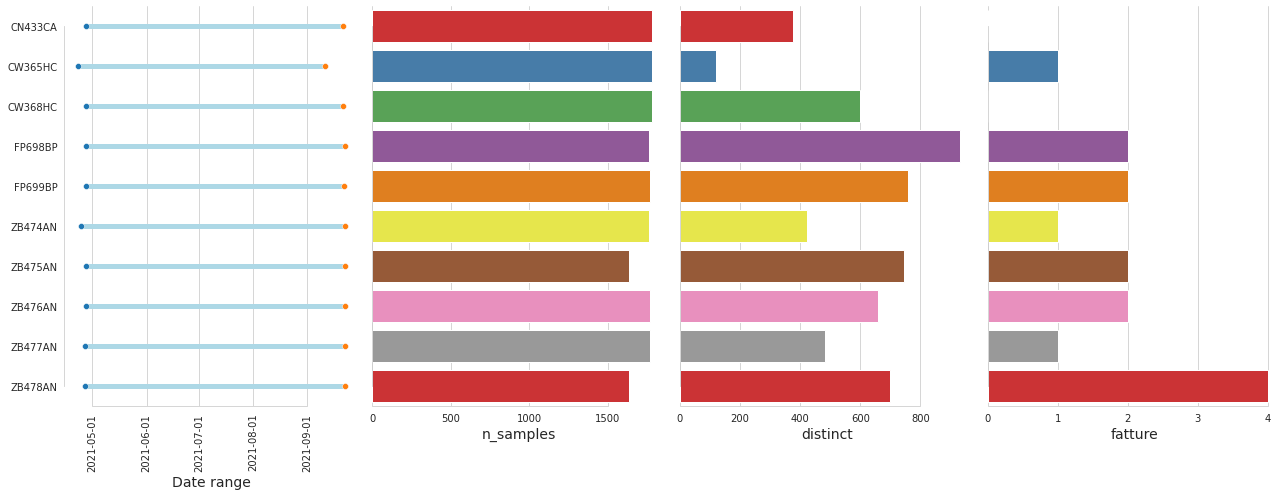

In [11]:
fig, ax = plt.subplots(1,4, figsize=(18,7), sharey=True)
sns.scatterplot(data=report, x="min", y="vehiclePlate", palette='Set1', ax=ax[0], zorder=4)
sns.scatterplot(data=report, x="max", y="vehiclePlate", palette='Set1', ax=ax[0], zorder=4)
ax[0].hlines(data=report, y="vehiclePlate", xmin="min", xmax="max", linewidth=5, color='lightblue')
sns.barplot(data=report, x="n_samples", y="vehiclePlate", palette='Set1', ax=ax[1])
sns.barplot(data=report, x="distinct", y="vehiclePlate", palette='Set1', ax=ax[2])
sns.barplot(data=report, x="fatture", y="vehiclePlate", palette='Set1', ax=ax[3])

ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel("Date range")
for a in ax:
    a.set_ylabel("")
    a.set_xlabel(a.get_xlabel(), size=14)
#     a.grid(False)
    a.yaxis.grid(False)
    sns.despine(trim=True)
    
plt.tight_layout()

---
## Analisi Misurazioni giornaliere

In [12]:
tmp = pd.read_csv("dataset/VISIRUN_CurrentPosition.csv", index_col=0)
tmp[tmp.vehiclePlate == "CW367HC"].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates()

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,timezone,lat,lon,workMinutes,statusCode,key,speed,odometer,heading
69,60013574,CW367HC Porter,CW367HC,2020-12-16T11:31:16,Cantiere La Spezia,Europe/Rome,45.237946,7.557693,201223.0,0.0,0.0,1.9,132990590.0,0.0


In [72]:
df_FOO.head()

,remoteUnitSerial,vehicleName,plate,odometer,engineOnTime,filename,Date
0,60039415,GC554HZ,GC554HZ,166899.1,18031:24,2021-04-30-14-40,2021-04-27
1,60039226,VISIRUN BOX 8,GDT00380,N.A.,N.A.,2021-04-30-14-40,2021-04-22
2,60013499,EV166DN,EV166DN,127606.42,15758:54,2021-04-30-14-40,2021-04-27
3,60013442,CW365HC,CW365HC,25376.17,3149:03,2021-04-30-14-40,2021-04-27
4,60013596,CX199WX,CX199WX,368722.54,2827:53,2021-04-30-14-40,NaN


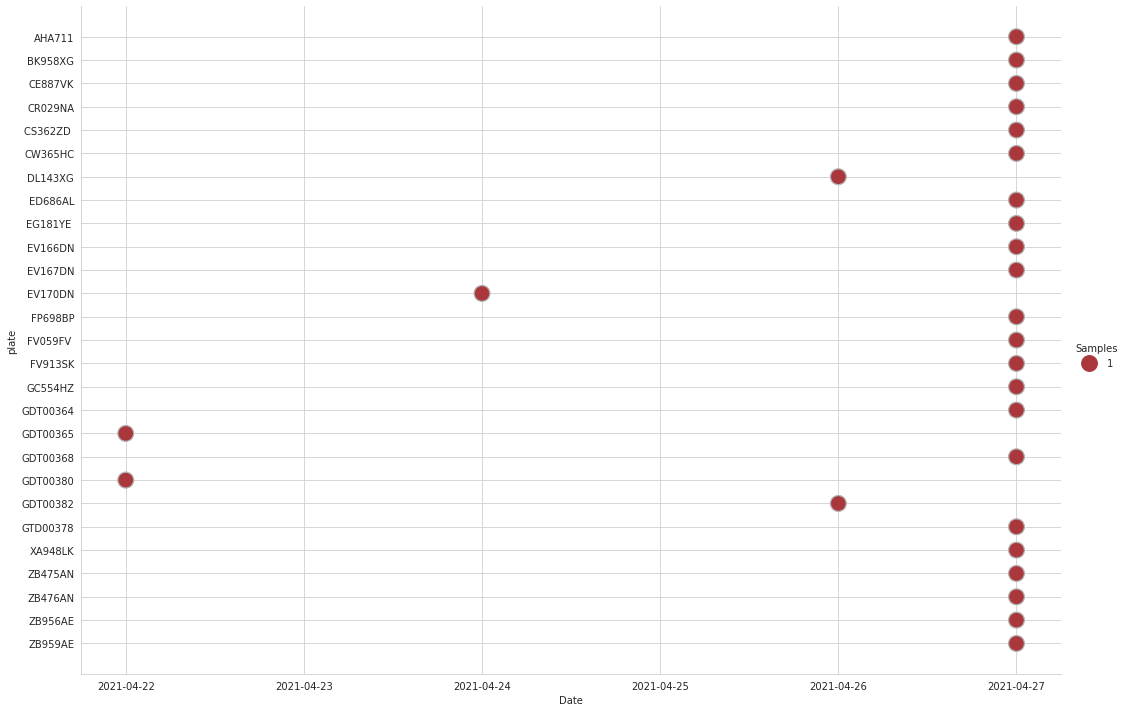

In [73]:
plot_date_relplot(df_FOO, timestamp="datestamp", plate="plate")

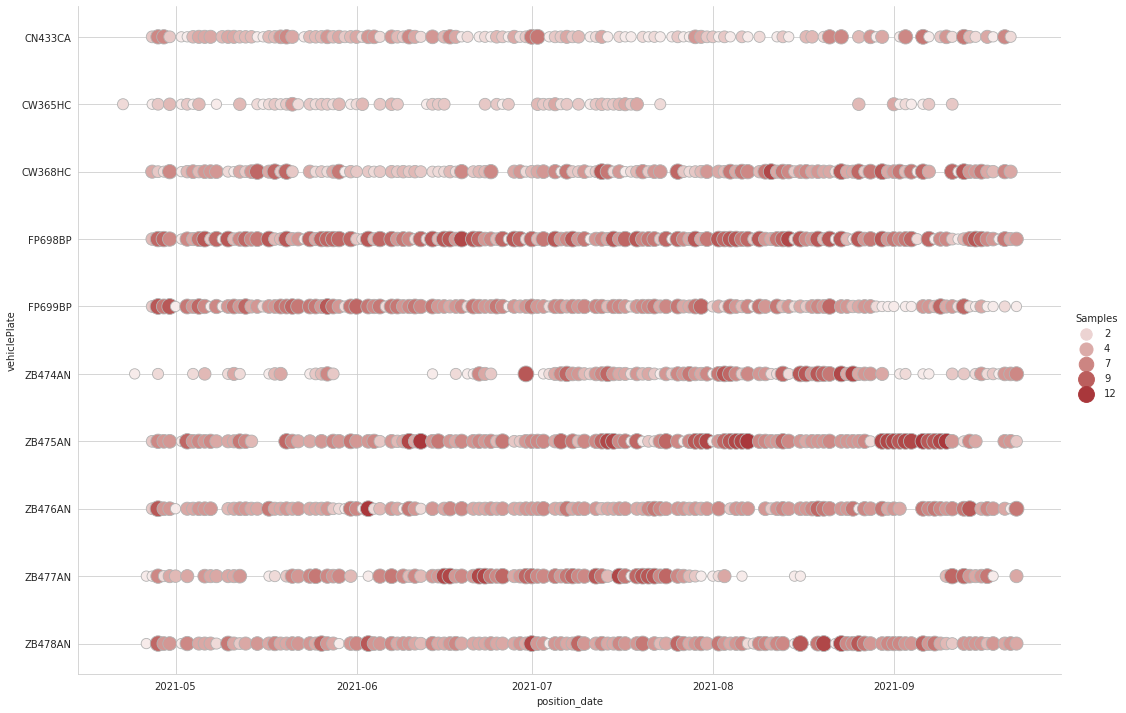

In [13]:
df_VIS_vehicles["position_date"] = df_VIS_vehicles.datestamp.dt.date
tmp = df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates().sort_values(by="position_date").groupby(["vehiclePlate", "position_date"], as_index=False).key.count()
tmp['c'] = tmp.key / tmp.key.max()
g = sns.relplot(
    data=tmp,
    x="position_date", y="vehiclePlate", hue="c", size="c",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8), aspect=1.5
)

for t in g._legend.get_texts():
    t.set_text(int(float(t.get_text())*tmp.key.max()))
g._legend.set_title("Samples")

Text(0, 0.5, 'count')

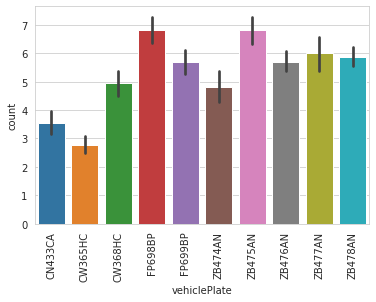

In [14]:
g = sns.barplot(data=tmp, x="vehiclePlate", y="key")
g.tick_params(axis='x', rotation=90)
g.set_ylabel("count")

---
## Monotonia

In [15]:
df_VIS_vehicles = df_VIS_vehicles[df_VIS_vehicles.datestamp.dt.year==2021].drop(["filename", "lastCommunicationDatetime"], axis=1).drop_duplicates()

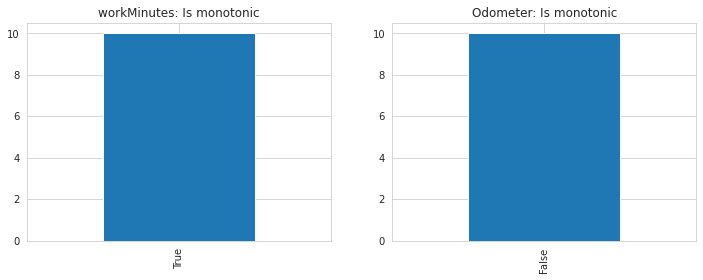

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df_VIS_vehicles.groupby('vehiclePlate').workMinutes.apply(lambda x: x.is_monotonic_increasing).value_counts().sort_values(ascending=True).plot(kind="bar", title=f"workMinutes: Is monotonic", ax=ax[0])
df_VIS_vehicles.groupby('vehiclePlate').odometer.apply(lambda x: x.is_monotonic_increasing).value_counts().plot(kind="bar", title="Odometer: Is monotonic", ax=ax[1])
plt.show()

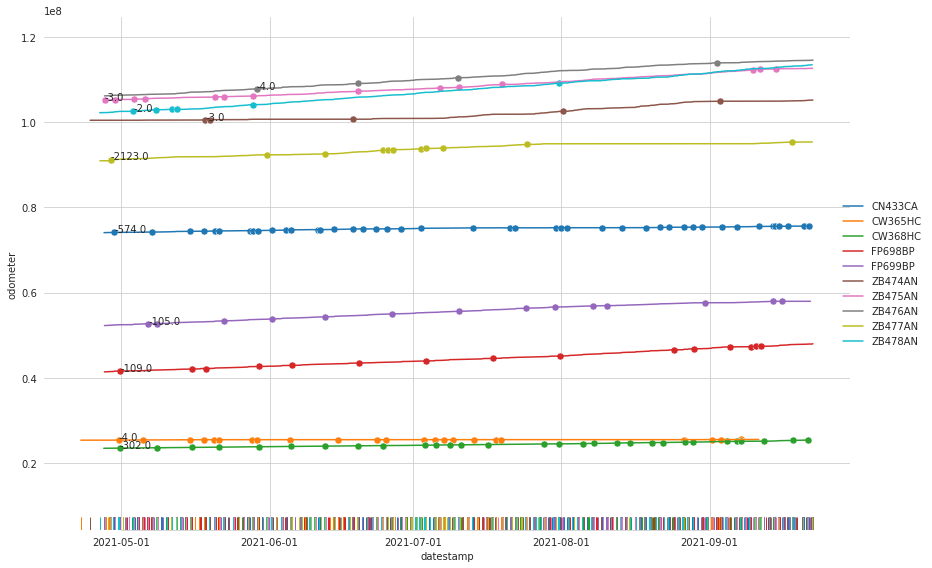

In [17]:
fig, ax = plt.subplots(figsize=(12,8), sharex=True)
# sns.lineplot(data=df_VIS_vehicles, x="datestamp", y="workMinutes", hue="vehiclePlate", ax=ax[0])
# sns.rugplot(data=df_VIS_vehicles, x="datestamp", hue="vehiclePlate", ax=ax[0])

sns.lineplot(data=df_VIS_vehicles, x="datestamp", y="odometer", hue="vehiclePlate", ax=ax)
sns.rugplot(data=df_VIS_vehicles, x="datestamp", hue="vehiclePlate", ax=ax)

for i, (vehiclePlate, d) in enumerate(df_VIS_vehicles.groupby('vehiclePlate')[["datestamp", "odometer"]]):
    d["df"] = d.odometer.diff().fillna(0)
    sns.scatterplot(data=d[d.df<0], x="datestamp", y="odometer", markers="*", s=50)
    plt.text(x=d[d.df<0].datestamp.values[0], y=d[d.df<0].odometer.values[0], s=str(d[d.df<0].df.values[0]))

fig.tight_layout()
# ax[1].get_legend().remove()

sns.despine(trim=True, left=True)
ax.legend(frameon=False, loc="center right", bbox_to_anchor=(1.1,0.5))
plt.show()

---
## Correlation

In [22]:
df_VIS_vehicles.head()

,remoteUnitSerial,vehicleName,vehiclePlate,datestamp,vehicleCategory,lat,lon,workMinutes,key,speed,odometer,heading,position_date
0,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 08:56:56,Raimondi,44.699753,8.016591,132346.0,0.0,0.0,74059763.0,67.03,2021-04-27
1,60013442,CW365HC,CW365HC,2021-04-22 12:23:42,Cantiere La Spezia,45.960865,8.420048,188839.0,0.0,0.0,25343610.0,231.28,2021-04-22
2,60013445,CW368HC,CW368HC,2021-04-27 07:32:19,Cantiere La Spezia,45.716534,10.093649,160000.0,0.0,0.0,23440240.0,127.25,2021-04-27
3,60009121,CN433CA PIAGGIO,CN433CA,2021-04-27 10:01:28,Raimondi,44.678673,7.987436,132346.0,1.0,33.4,74068039.0,58.04,2021-04-27
5,60013445,CW368HC,CW368HC,2021-04-27 10:00:03,Cantiere La Spezia,45.717937,10.079244,160000.0,1.0,24.1,23441293.0,195.31,2021-04-27


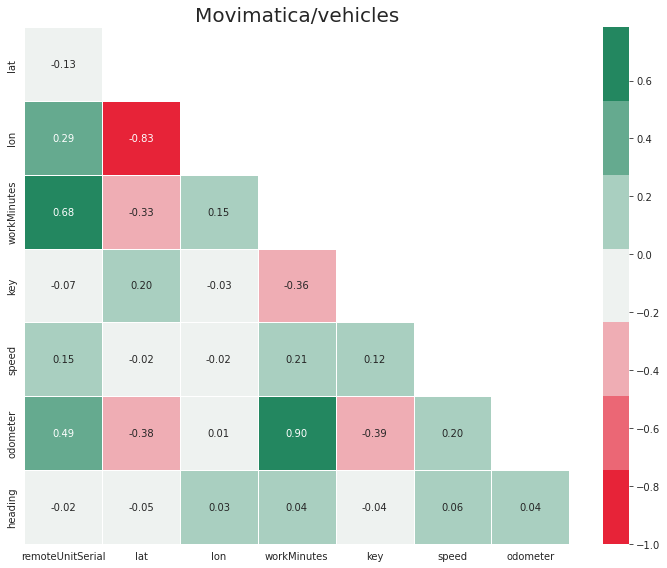

In [23]:
pseudo_plate = [c for c in df_VIS_vehicles.columns if len(df_VIS_vehicles[c].unique()) == 35]
correlations = df_VIS_vehicles.drop(pseudo_plate, axis=1).corr()

fig, ax = plt.subplots(figsize=(10,8))
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
heatmap = sns.heatmap(correlations.iloc[1:,:-1], annot=True, fmt='.2f', linewidths=0.5,
            mask=mask[1:,:-1], ax=ax, cmap=sns.diverging_palette(10, 150, s=90, n=7),
            robust=True, vmin=-1)#, annot_kws={"size": 10})
plt.title("Movimatica/vehicles", size=20)
plt.tight_layout()
# fig.savefig("corr.png")

---
## PCA

In [31]:
df_VIS_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])

remoteUnitSerial     True
vehicleName         False
vehiclePlate        False
datestamp           False
vehicleCategory     False
lat                  True
lon                  True
workMinutes          True
key                  True
speed                True
odometer             True
heading              True
position_date       False
dtype: bool

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# numerical_cols = df_VIS_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# numerical_cols = df_VIS_vehicles.dtypes.isin([np.dtype('int64'), np.dtype('float64'), np.dtype('bool')])
# data_std = df_VIS_vehicles[numerical_cols[numerical_cols].index].drop(["id", "alarm_id"], axis=1)
data_std = df_VIS_vehicles[["lat", "lon", "workMinutes", "key", "speed", "odometer", "heading"]].copy()

data_std[data_std.columns] = StandardScaler().fit_transform(data_std[data_std.columns])
data_std.head()

,lat,lon,workMinutes,key,speed,odometer,heading
0,-0.093389,-1.264201,-1.611776,-0.426298,-0.474531,-0.094893,-1.084729
1,0.666462,-0.992562,-1.118247,-0.426298,-0.474531,-1.612937,0.461051
2,0.519246,0.134242,-1.370188,-0.426298,-0.474531,-1.672248,-0.517990
3,-0.106091,-1.283831,-1.611776,2.345774,1.849444,-0.094635,-1.169335
5,0.520092,0.124543,-1.370188,2.345774,1.202349,-1.672215,0.122532


In [36]:
data_std = data_std.dropna()
pca = PCA(n_components=4)
pca.fit(data_std)
projection = pca.transform(data_std)

In [37]:
var_ratio = pca.explained_variance_ratio_
var_ratio

array([0.36016789, 0.22257777, 0.15825767, 0.14121792])

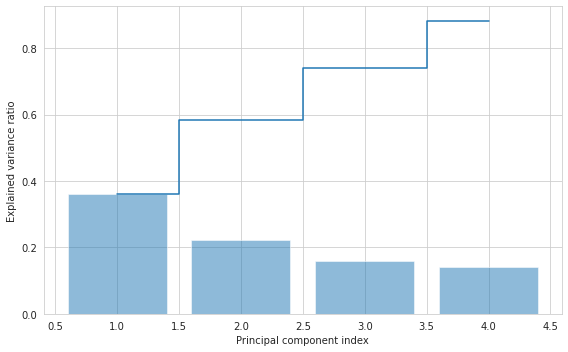

In [38]:
cum_sum_eigenvalues = np.cumsum(var_ratio)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(var_ratio) + 1), var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_ratio) + 1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig("PCA_6")
plt.show()

In [39]:
most_important = [np.argpartition(np.abs(pca.components_[i]), -3)[-3:] for i in range(len(var_ratio))]

In [40]:
initial_feature_names = data_std.columns
most_important_names = {i: initial_feature_names[most_important[i]].to_list() for i in range(len(var_ratio))}

In [41]:
most_important_names

{0: ['lat', 'odometer', 'workMinutes'],
 1: ['odometer', 'lat', 'lon'],
 2: ['heading', 'speed', 'key'],
 3: ['speed', 'key', 'heading']}

## FleetOdometerOld

In [44]:
df_FOO = pd.read_csv("dataset/VISIRUN_FleetOdometerOld.csv", index_col=0)
df_FOO[df_FOO.plate.isin(targhe)]

,remoteUnitSerial,vehicleName,plate,odometer,engineOnTime,filename
3,60013442,CW365HC,CW365HC,25376.17,3149:03,2021-04-30-14-40
9,60025946,FP698BP,FP698BP,41585.45,3126:41,2021-04-30-14-40
10,60025915,ZB476AN Azimut 6,ZB476AN,106365.02,6894:17,2021-04-30-14-40
24,60025920,FP699BP,FP699BP,52440.6,4464:18,2021-04-30-14-40
27,60048783,FV913SK,FV913SK,50459.6,381:02,2021-04-30-14-40
45,60013445,CW368HC,CW368HC,23480.6,2672:23,2021-04-30-14-40
50,60039269,ZB127AR,ZB127AR,60617.71,1924:23,2021-04-30-14-40
64,60048788,ZB132AR,ZB132AR,68855.15,4133:41,2021-04-30-14-40
70,60025959,ZB473AN Azimut 6,ZB473AN,76996.71,4730:25,2021-04-30-14-40
74,60013574,CW367HC Porter,CW367HC,132990.59,3353:43,2021-04-30-14-40


## RawTachodata

In [45]:
df_tacho = pd.read_csv("dataset/VISIRUN_RawTachoData.csv", index_col=0)


In [49]:
pd.read_csv("dataset/VISIRUN_KpiSummary.csv", index_col=0).drop("filename", axis=1).drop_duplicates()

,driveTime,workTime,idleTime,stopTime,distance,consumption,wastedFuel,timestampCall
0,139:55,220:45,80:49,570:36,2839293,455,158,2021-05-03 09:08:45.473678100+00:00
0,140:32,221:45,81:12,571:04,2856089,459,162,2021-05-03 09:10:00.268153500+00:00
0,142:45,224:42,81:56,574:02,2916668,463,164,2021-05-03 09:15:00.212408400+00:00
0,144:55,227:50,82:55,576:49,2981995,471,166,2021-05-03 09:20:00.306529200+00:00
0,146:41,230:31,83:49,580:03,3035573,477,166,2021-05-03 09:25:00.199093800+00:00
...,...,...,...,...,...,...,...,...
0,166:56,257:26,90:30,835:03,4303189,723,274,2021-09-22 13:50:00.247766200+00:00
0,167:20,258:14,90:54,840:00,4322945,728,274,2021-09-22 13:55:00.263224200+00:00
0,167:46,259:22,91:36,844:37,4341837,740,275,2021-09-22 14:00:00.561962200+00:00
0,168:22,259:52,91:30,849:52,4361978,745,278,2021-09-22 14:05:00.506258900+00:00


In [54]:
df_kpisumm = pd.read_csv("dataset/VISIRUN_KpiSummary.csv", index_col=0).drop("filename", axis=1).reset_index(drop=True)

df_kpisumm.timestampCall = pd.to_datetime(df_kpisumm.timestampCall, format="%Y-%m-%d %H:%M:%S.%f%z", utc=True)

df_kpisumm

,driveTime,workTime,idleTime,stopTime,distance,consumption,wastedFuel,timestampCall
0,139:55,220:45,80:49,570:36,2839293,455,158,2021-05-03 09:08:45.473678100+00:00
1,140:32,221:45,81:12,571:04,2856089,459,162,2021-05-03 09:10:00.268153500+00:00
2,142:45,224:42,81:56,574:02,2916668,463,164,2021-05-03 09:15:00.212408400+00:00
3,144:55,227:50,82:55,576:49,2981995,471,166,2021-05-03 09:20:00.306529200+00:00
4,146:41,230:31,83:49,580:03,3035573,477,166,2021-05-03 09:25:00.199093800+00:00
...,...,...,...,...,...,...,...,...
40873,166:56,257:26,90:30,835:03,4303189,723,274,2021-09-22 13:50:00.247766200+00:00
40874,167:20,258:14,90:54,840:00,4322945,728,274,2021-09-22 13:55:00.263224200+00:00
40875,167:46,259:22,91:36,844:37,4341837,740,275,2021-09-22 14:00:00.561962200+00:00
40876,168:22,259:52,91:30,849:52,4361978,745,278,2021-09-22 14:05:00.506258900+00:00


In [65]:
pd.to_datetime(df_kpisumm.driveTime, format="%M:$S")

ValueError: time data '139:55' does not match format '%M:$S' (match)